In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import datasets, model_selection, metrics
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr


from functions import *

# 1. Data Exploration & Cleaning

## 1.1 Demographics Table

In [2]:
# Load data
df_demo = pd.read_csv('../data/raw/df_final_demo.txt')

# Rename columns and explore table
df_demo = rename_demo_columns(df_demo)
data_exploration(df_demo)

Number of rows: 70609
Number of columns: 9
Number of duplicates: 0

Numerical Columns: Index(['client_id', 'tenure_year', 'tenure_month', 'age', 'number_of_accounts',
       'balance', 'calls_6_month', 'logons_6_month'],
      dtype='object')

Categorical Columns: Index(['gender'], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,70609,0,70609
1,tenure_year,float64,70595,14,54
2,tenure_month,float64,70595,14,482
3,age,float64,70594,15,165
4,gender,object,70595,14,4
5,number_of_accounts,float64,70595,14,8
6,balance,float64,70595,14,70328
7,calls_6_month,float64,70595,14,8
8,logons_6_month,float64,70595,14,9


<ins>Observations:</ins>
- For some client_ids we find a few missing values (14 to 15). Taking into account the large number of total rows (> 70k), we can fill the mising values with mean and mode for numerical and categorical columns, respectively, without changing the distribution.
- In the columns we identify seven numerical variables ('tenure_year', 'tenure_month', 'age', 'number_of_accounts', 'balance', 'calls_6_month', 'logons_6_month'), all with data type float. Some numerical variables should be integer instead ('number_of_accounts', 'calls_6_month', 'logons_6_month'). In addition, we find two categorical variables ('gender', 'client_id'), of which one ('client_id') is of type integer, but should better be string (object-type).

In [3]:
# Select categorical and numerical columns
cols_demo_numerical = ['tenure_year', 'tenure_month', 'age', 'number_of_accounts', 'balance', 'calls_6_month', 'logons_6_month']
cols_demo_categorical = ['gender', 'client_id']

# Fill missing values in numerical columns with the mean and in categorical columns with the mode
df_demo = fill_missing(df_demo, cols_demo_numerical, cols_demo_categorical)

# Change discrete numerical variables from type float to integer + client_id from integer to object
df_demo[['number_of_accounts', 'calls_6_month', 'logons_6_month']] = df_demo[['number_of_accounts', 'calls_6_month', 'logons_6_month']].astype(("int64"))
df_demo['client_id'] = df_demo['client_id'].astype(str)

# Save cleaned dataframe to csv-file
df_demo.to_csv("../data/cleaned/df_final_demo_cleaned.csv", index=False)

## 1.2 Web Data Table

In [4]:
# Load data
df_web_data_pt_1 = pd.read_csv('../data/raw/df_final_web_data_pt_1.txt')
df_web_data_pt_2 = pd.read_csv('../data/raw/df_final_web_data_pt_2.txt')

# Concatenate two parts
df_web_data = pd.concat([df_web_data_pt_1, df_web_data_pt_2], axis=0)

# Explore table
data_exploration(df_web_data)

Number of rows: 755405
Number of columns: 5
Number of duplicates: 10764

Numerical Columns: Index(['client_id'], dtype='object')

Categorical Columns: Index(['visitor_id', 'visit_id', 'process_step', 'date_time'], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,755405,0,120157
1,visitor_id,object,755405,0,130236
2,visit_id,object,755405,0,158095
3,process_step,object,755405,0,5
4,date_time,object,755405,0,629363


<ins>Observations:</ins>
- We find about 11k duplicates on a total of about 750k rows. We expect the duplicates to originate from technical errors in the data collection (e.g. a client clicks on a button and this action is recorded two times).
- As in the demographics table, also here the client_id is of type integer, but should be object.
- The date_time column is of type object. We convert it to datetime and split the column in two: date and time.

In [5]:
# Select categorical and numerical columns
cols_web_numerical = []
cols_web_categorical = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'data_time']

In [6]:
# Change client_id column from type integer to object
df_web_data['client_id'] = df_web_data['client_id'].astype(str)

# Change date_time column from type object to datetime and split into date and time
df_web_data['date_time'] = pd.to_datetime(df_web_data['date_time'])
#df_web_data['date'] = df_web_data['date_time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
#df_web_data['time'] = df_web_data['date_time'].apply(lambda x: pd.to_datetime(x, format='%H:%M:%S.%f'))
#df_web_data = df_web_data.drop(columns='date_time')

# Drop duplicates
df_web_data = df_web_data.drop_duplicates()

# Save cleaned dataframe to csv-file
df_web_data.to_csv("../data/cleaned/df_final_web_data_cleaned.csv", index=False)

## 1.3 Experiment Clients Table

In [7]:
# Load data
df_clients = pd.read_csv('../data/raw/df_final_experiment_clients.txt')

# Rename column and explore table
df_clients = df_clients.rename(columns={'Variation': 'variation'})
data_exploration(df_clients)

Number of rows: 70609
Number of columns: 2
Number of duplicates: 0

Numerical Columns: Index(['client_id'], dtype='object')

Categorical Columns: Index(['variation'], dtype='object')


,Column,Data Type,Non-Null Count,Missing Values,Unique Values
0,client_id,int64,70609,0,70609
1,variation,object,50500,20109,2


<ins>Observations:</ins>
- We find about 20k missing values in a total of about 120k total values. As the information about a client being in the test or the control group is critical for the analysis, we decide to drop the rows with missing values.
- Again, the client_id column should be of type object instead of integer.

In [8]:
# Select categorical and numerical columns
cols_clients_numerical = []
cols_clients_categorical = ['client_id', 'variation']

In [9]:
# Change client_id column from type integer to object
df_clients['client_id'] = df_clients['client_id'].astype(str)

# Drop all missing values
df_clients = df_clients.dropna(subset=["variation"])

# Save cleaned dataframe to csv-file
df_clients.to_csv("../data/cleaned/df_final_experiment_clients_cleaned.csv", index=False)

# 2. Exploratory Data Analysis

## 2.1 Univariate EDA

### 2.1.1 Demographics Table

In [10]:
# Discretizing 'age' into 4 categories
bins = [12, 19, 39, 59, 100]
labels = ['Teenagers', 'Young Adults', 'Adults', 'Seniors']
df_demo['age_group'] = pd.cut(df_demo['age'], bins=bins, labels=labels, include_lowest=True).astype('object')

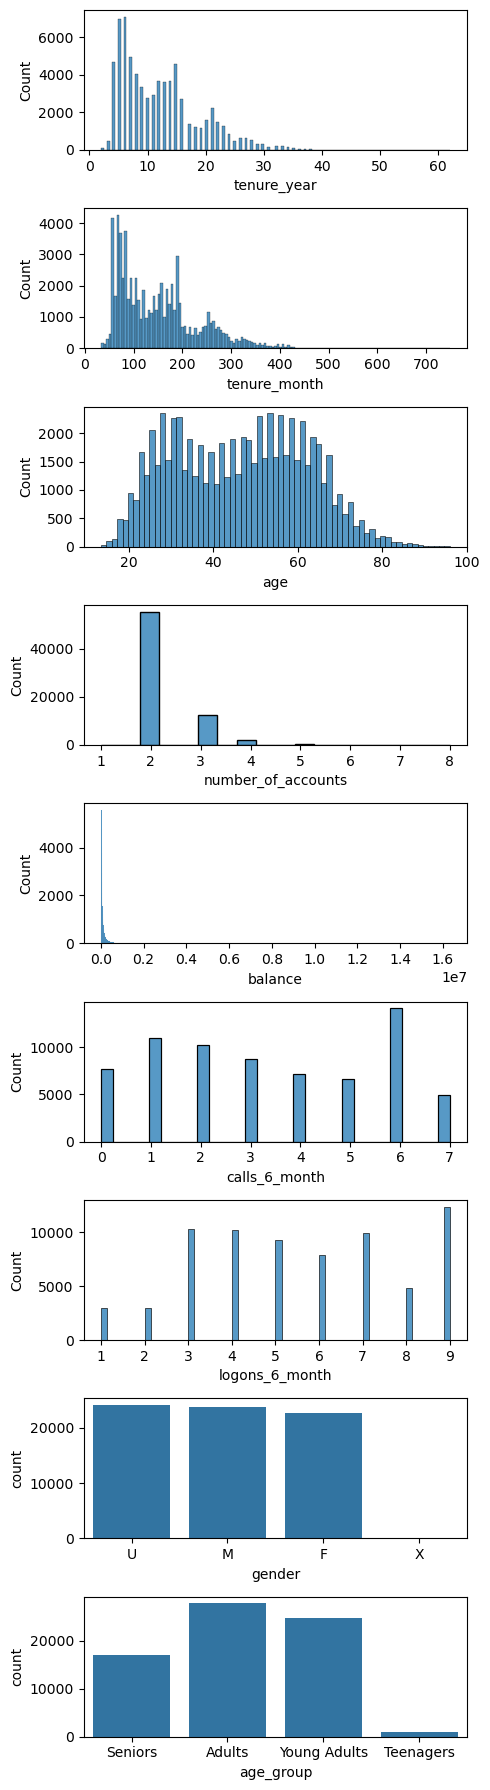

In [11]:
# Investigate distributions
plot_distributions_numerical(df_demo, cols_demo_numerical + ['gender', 'age_group'])

<ins>Observations</ins>
- Tenure year (and month): the distribution suggests that there are years in which subsequently more people become clients and then there are years in which the acquisition of clients declines again.
- Age: the distribution shows two distinct peaks, which could be related to the trends in client acqusition seen above. In general there is a wide range of age and no trend is to be observed.
- Number of accounts: most people have two accounts, some have three and only very few have four or more.
- Balance: Most clients have a relatively low balance compared to much fewer clients with higher balances.
- Calls: The big majority of clients called at least once in the last six months. For a number of six calls, we find a very distinct spike, which could be due to monthly jours fixes. There are no clients with a number of calls larger than seven, which is - taking into account the large sample size - unexpected.
- Logons: The big majority of clients logged on at least three times in the last six months, and above that value, the number of logons is quite equally distributed. For a number of eight logons, however, the count is very low compared to seven and nine. In addition, there is no logon number higher than nine, which requires an explanation, as naturally the distribution would be expected to fade out for higher numbers.
- Gender: For around a third of the clients, there is no information about their gender available. For the remaining two thirds, the number of females is a bit higher than the number of males.

### 2.1.2 Web Data Table

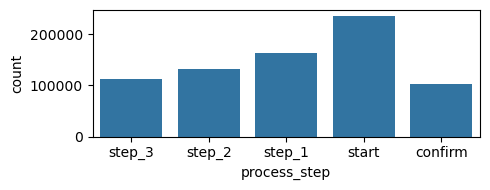

In [12]:
# Investigate distributions
plot_distributions_numerical(df_web_data, ['process_step'])

<ins>Observations</ins>
- There are about two times as much start actions as confirm actions.

### 2.1.3 Experiment Clients Table

In [13]:
# Investigate distributions
df_clients['variation'].value_counts()

variation
Test       26968
Control    23532
Name: count, dtype: int64

<ins>Observations</ins>
- There are about 15% more clients in the test than in the control group.

## 2.2 Bivariate EDA

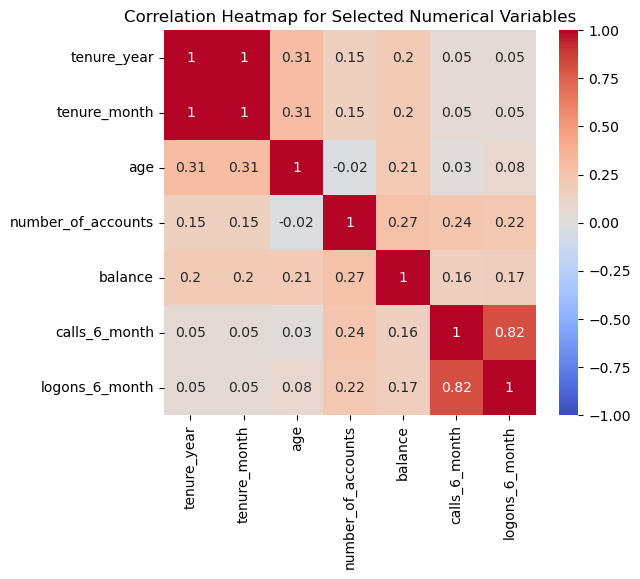

In [14]:
create_correlation_matrix(df_demo, cols_demo_numerical)

<ins>Observations</ins>
- Age and tenure year/month are correlated: the older the clients, the longer they have been clients.
- Balance is correlated with all other variables: the higher the balance, the longer the clients are already clients, the older they are, the more accounts they have, the higher the number of calls and logons in the six months.
- Number of logons and calls are very strongly correlated.

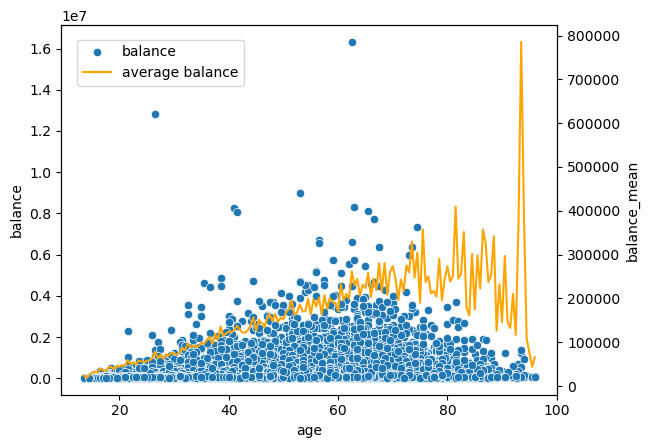

In [15]:
# Investigate association of age and balance
plot_balance_vs_age(df_demo)

# 3. Experiment Evaluation

In [16]:
# merge tables and only consider clients present in all three tables
df_ = pd.merge(df_web_data, df_clients, on='client_id', how='inner')
df = pd.merge(df_, df_demo, on='client_id', how='inner')

# Add extra column indicating the day counting from the start of the trial
df["day_of_trial"] = df["date_time"].dt.dayofyear - df["date_time"].sort_values().dt.dayofyear.iloc[0]

# Add extra column to identify really unique sessions
df['unique_session_id'] = df['client_id'] + '_' + df['visit_id']

In [17]:
#g = sns.FacetGrid(df, row="variation", hue="variation", height=2, aspect=3)
#g.map(sns.histplot, "calls_6_month")

## 3.1 Design Effectiveness

Bias Test vs Control: 


<Axes: xlabel='bias', ylabel='variable'>

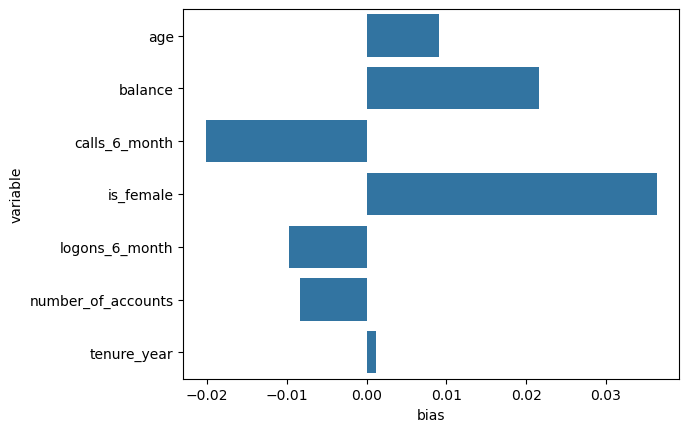

In [18]:
# check for bias in the test and control group for the different variables
biases = experiment_evalutaion(df)
sns.barplot(biases, y="variable", x="bias")

<ins>Observations:</ins>
* Maximum bias is 4%, which appears in the gender category.
* In general, the bias is acceptable for the experiment.

## 3.2 Duration Assessment

<Axes: xlabel='day_of_trial'>

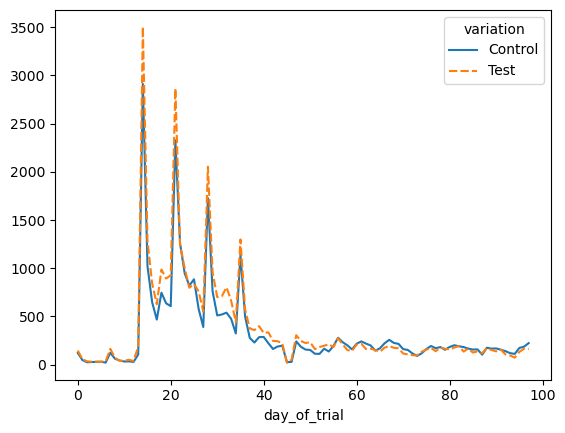

In [19]:
# check number of visits per day for both groups
visits_daily = df.pivot_table(index="day_of_trial", values="visit_id", columns="variation", aggfunc="nunique")
sns.lineplot(visits_daily)

In [20]:
calculate_avg_daily_visits_per_time_period(visits_daily)

Average Daily Visits
--------------------
In the last two weeks of March: 120
In April: 1531
In May and June: 338


<ins>Observations:</ins>
* During the first two weeks, the access rate to the page is relatively low.
* On Wednesdays, the visit rate tends to be higher than on other days.
* The access rate increases significantly after the first two weeks and in April shows very distinct spikes on the Wednesdays. The high acticity rate in April is probably due to the deadline for filing federal income tax returns in the U.S.
* In March and June, the rate is much lower again, but remains on a relatively steady number that is higher than for the first two weeks.

<ins>Conclusion:</ins>
* ...

# 4. KPIs

## 4.1 Completion Rate
- Number of users who reached the ‘confirm’ step in relation to the total number of users in that group

## 4.2 Time Spent on each Step
- Get time difference between each step for each visit
- Calculate average duration users spend on each step before moving to the next

## 4.3 Error Rates
Every time a user goes a step back, this is counted as an error. The error rate is the number of errors per session. Here the average error rate per day is considered.

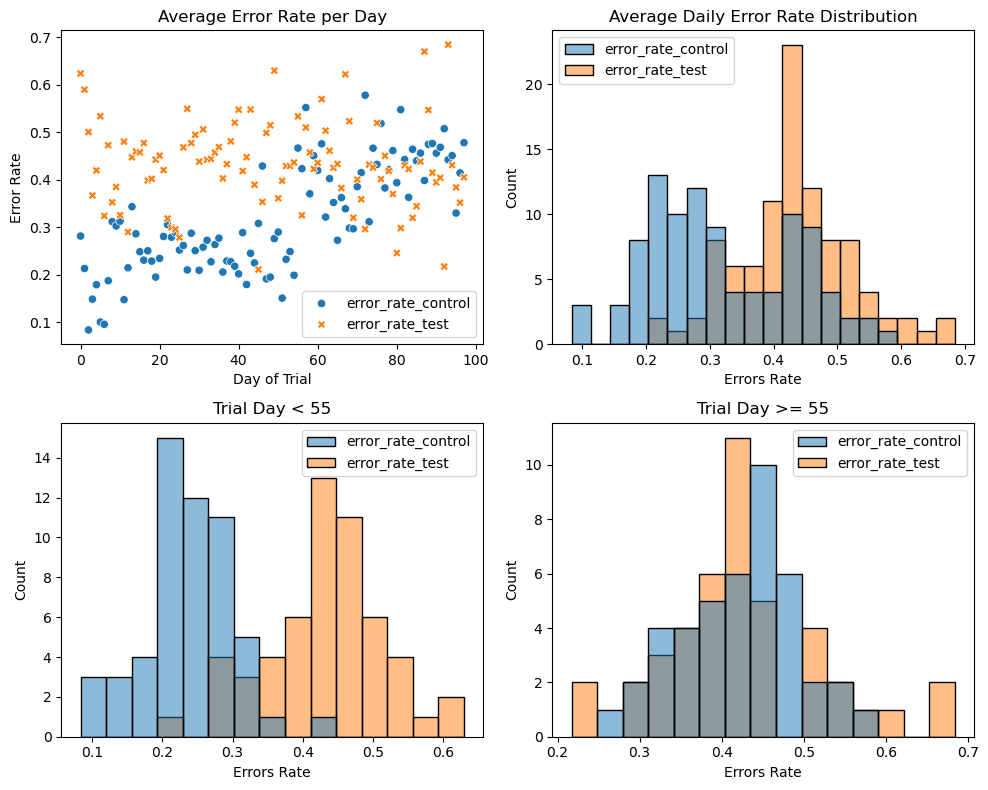

In [21]:
# calculate average errors per day for test and control group
errors_daily = calculate_grouped_error_rates(df, grouping_column="day_of_trial")
errors_daily_to_csv(errors_daily)

# plot average errors per day
plot_avg_errors_per_day(errors_daily)

In [22]:
# calculate the average daily error rates for different time periods of the experiment
calculate_avg_error_rates_per_time_period(df)

Daily Average Error Rates
-------------------------

In total
Control: 29.7%
Test: 43.6%

Trial Day < 55
Control: 25.9%
Test: 43.8%

Trial Day >= 55
Control: 42.1%
Test: 42.9%


<ins>Observations:</ins>
* The total average error rate for the test group is higher than for the control group (43.6% vs 29.7%).
* In the first 55 days of the experiment, the difference is even higher (43.8% vs 25.9%).
* After the first 55 days, the difference decreases to a very slight difference (42.9% vs 42.1%).
* The distributions of the average error rates per day for the test and the control group can be interpreted as the combination of two normal-like distributions (especially the one for the control group), originating from the first 55 days of the experiment and the remaiming days.

# 5. Hypothesis Testing

## 5.1 Completion Rate
- Null hypothesis: completion rate of old feature = completion rate of new feature
- Alternative hypothesis: completion rate of old feature != completion rate of new feature

## 5.2 Time Spent on each Step
- Null hypothesis: time spent on completion of old feature = time spent completion rate of new feature
- Alternative hypothesis: time spent completion rate of old feature != time spent completion rate of new feature

## 5.2 Error Rates

### 5.2.1 Test Group vs Control Group
* H0: Control group has the same or a higher average error rate per day compared to the test group.
* H1: Control group has a lower average error rate per day compared to the test group.

In [33]:
# perform t-test for H0
error_rates_hypothesis_test_vs_control(errors_daily)

p-values for H0
All Trial Days: 3.0e-13
Trial Day < 55: 2.1e-25
Trial Day >= 55: 3.9e-01


--> Reject Null Hypothesis for total experiment and the time before day 55 of the trial, but do not reject Null Hypothesis for the time after day 55 of the trial.

### 5.2.2 Early vs Late Trial Days
#### 5.2.2.1 Test Group
* H0: The average error rate per day in the test group is the same before trial day 55 compared to day 55 and later.
* H1: The average error rate per day in the test group is not the same before trial day 55 compared to day 55 and later.

In [34]:
# perform t-test for H0
error_rates_hypothesis_early_vs_late_test(errors_daily)

p-value for H0: 6.6e-01


--> Do not reject Null Hypothesis.

#### 5.2.2.2 Control Group
* H0: The average error rate per day in the test group is the same before trial day 55 compared to day 55 and later.
* H1: The average error rate per day in the test group is not the same before trial day 55 compared to day 55 and later.

In [35]:
# perform t-test for H0
error_rates_hypothesis_early_vs_late_control(errors_daily)

p-value for H0: 6.8e-23


--> Reject Null Hypothesis.

### 5.2.3 Conclusion
...